<a href="https://colab.research.google.com/github/ThiagoMartinsThome/TFM/blob/master/ExtratreeRegressor_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score,  cross_validate
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline, make_union
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, RobustScaler
from sklearn.pipeline import FeatureUnion
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import joblib
from sklearn.metrics import mean_squared_error , mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV


sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load and prepare the data

#### Load the data

In [20]:
!unzip /content/drive/My Drive/Colab Notebooks/TFM/tradebot_tfm/data_20day_chg_target.zip

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TFM/tradebot_tfm/data_20day_chg_target.zip', parse_dates=['date'])

# load data
data = df.copy()
data.drop('long_name', axis=1, inplace=True)
data.dropna(inplace=True, axis=0)
data.sort_values(by=['ticker', 'date'], ascending=True, inplace=True)
data.set_index('date', inplace=True)

print('Null values: ', data.isnull().sum().sum())

data.head()

unzip:  cannot find or open /content/drive/My, /content/drive/My.zip or /content/drive/My.ZIP.
Null values:  0


,ticker,open,high,low,close,volume,sp_open,sp_high,sp_low,sp_close,sp_volume,sp_percent_change,percent_change,relative_change,year,month,day,day_of_year,week_of_year,quarter,f_14_period_rsi,f_14_period_stoch_k,f_20_period_cci,up_move,down_move,plus,minus,f_14_period_adx,diplus,diminus,ao,mom,macd,signal_x,f_14_period_stochastic_rsi,f_14_williams_r,bull,bear,uo,f_8_period_vama,deltawma,f_16_period_hma,tenkan,kijun,f_9_period_smm,f_9_period_ssma,f_9_period_dema,f_9_period_tema,f_18_period_trima,f_20_period_trix,f_10_period_er,f_20_period_kama,f_26_period_zlema,f_9_period_wma,f_20_period_evwma,vwap,ppo,signal_y,histo,roc,f_5_period_sma,f_5_period_ema,f_10_period_sma,f_10_period_ema,f_20_period_sma,f_20_period_ema,f_30_period_sma,f_30_period_ema,f_50_period_sma,f_50_period_ema,f_100_period_sma,f_100_period_ema,f_200_period_sma,f_200_period_ema,short_result,sector,industry
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1993-11-11,AAPL,0.921914,0.959390,0.914418,0.940652,35607600.0,28.214053,28.289897,28.119247,28.138208,88900,-0.002688,0.020325,0.023013,1993.0,11.0,11.0,315.0,45.0,4.0,60.349555,59.374851,43.972860,3.747602e-02,-1.499032e-02,0.037476,0.000000e+00,36.022545,29.416429,13.493711,0.102574,0.011243,0.039989,0.044281,0.599610,-40.625149,0.039216,-0.005756,55.330429,0.945870,0.931399,0.937907,0.937112,0.862096,0.944400,0.907955,0.942416,0.926890,0.826442,0.539938,0.050848,0.926042,0.967849,0.935405,0.862179,1.191158,4.528958,5.123036,-0.594078,5.462147,0.928659,0.931656,0.940652,0.927735,0.912732,0.898806,0.842089,0.874856,0.806337,0.862869,0.866003,0.927067,1.220093,1.040218,-10.0,Information Technology,"Technology Hardware, Storage & Peripherals"
1993-11-12,AAPL,0.944399,0.959390,0.914418,0.951894,35915600.0,28.195089,28.365738,28.176128,28.270933,108200,0.004717,0.011952,0.007235,1993.0,11.0,12.0,316.0,45.0,4.0,61.832195,68.749683,44.949612,-1.787082e-07,1.703312e-07,0.000000,1.703312e-07,36.100008,27.315254,12.529900,0.095344,0.029981,0.039336,0.043292,0.592462,-31.250317,0.034684,-0.010287,61.292067,0.941706,0.933083,0.933950,0.938361,0.871321,0.948147,0.912837,0.947884,0.936265,0.837211,0.554601,0.133332,0.926584,0.966667,0.937237,0.864885,1.190371,4.429322,4.984293,-0.554971,0.000000,0.927910,0.938402,0.943650,0.932128,0.917979,0.903862,0.851084,0.879827,0.809935,0.866361,0.863433,0.927568,1.216010,1.039203,-7.0,Information Technology,"Technology Hardware, Storage & Peripherals"
1993-11-15,AAPL,0.944400,0.981876,0.944400,0.959390,39275600.0,28.327813,28.327813,28.176124,28.251968,243300,-0.000671,0.007875,0.008546,1993.0,11.0,15.0,319.0,46.0,4.0,62.830174,69.231257,72.776436,2.248626e-02,-2.998154e-02,0.022486,0.000000e+00,36.561073,28.873022,11.634907,0.093602,0.014991,0.038973,0.042428,0.587757,-30.768743,0.052215,0.014739,55.698258,0.943250,0.939213,0.935329,0.938778,0.882131,0.948147,0.918009,0.954242,0.945976,0.848118,0.566746,0.071429,0.926963,0.968349,0.940402,0.868122,1.189586,4.362565,4.859948,-0.497383,3.225861,0.935405,0.945398,0.945149,0.937085,0.923413,0.909151,0.860328,0.884960,0.813683,0.870011,0.860565,0.928209,1.211705,1.038288,-8.0,Information Technology,"Technology Hardware, Storage & Peripherals"
1993-11-16,AAPL,0.959390,1.026847,0.951895,1.019352,75770800.0,28.308858,28.403664,28.195092,28.384703,492600,0.004698,0.062500,0.057801,1993.0,11.0,16.0,320.0,46.0,4.0,69.663353,94.444463,131.443152,4.497108e-02,-7.494871e-03,0.044971,0.000000e+00,37.634356,33.828155,10.803841,0.100932,0.037476,0.043028,0.042548,0.583771,-5.555537,0.084373,0.009421,59.569664,0.957204,0.964699,0.947400,0.942109,0.893230,0.951894,0.929270,0.980103,0.981341,0.858864,0.582450,0.161291,0.929377,0.979344,0.956059,0.877925,1.188333,4.766695,4.841297,-0.074602,10.569099,0.958640,0.970049,0.948896,0.952042,0.932782,0.919646,0.870821,0.893630,0.818330,0.875869,0.858819,0.930045,1.207848,1.038071,-12.0,Information Technology,"Technology Hardware, Storage & Peripherals"
1993-11-17,AAPL,1.019352,1.

#### Define features and targets

In [21]:
# Define features and target
X, y = data.drop('short_result', axis=1), data['short_result']
train = data[(data['year'] <= 2017) & (data['year'] >= 2010)]
test = data[data['year'] > 2017]

X_train, y_train = train.drop('short_result', axis=1), train['short_result']
X_test, y_test = test.drop('short_result', axis=1), test['short_result']


Min value:  -52.54
Max value:  50.8


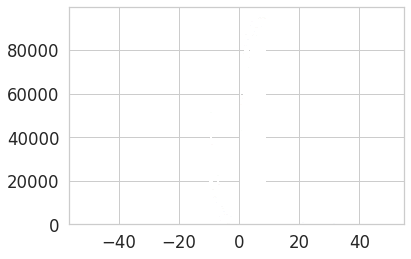

In [22]:
#Pipeline
#Column transformation
# determine categorical and numerical features
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns

# Column preparation
transformer = [
               ('onehot', OneHotEncoder(sparse=False), categorical_cols),
               ('scaler', StandardScaler(), numerical_cols),
               ]
col_transform = ColumnTransformer(transformers=transformer)

pipeline_x = Pipeline(steps=[('prep', col_transform),
                             ('pca', PCA(n_components=34, random_state=1)),
                             #('pca', PCA(.98, random_state=1))
                             ])
pipeline_y =  Pipeline(steps=[('scaler', StandardScaler())])

pipeline_x.fit(X)
pipeline_y.fit(y.values.reshape(-1, 1))

joblib.dump(pipeline_x, 'pipeline_x.pkl', compress=1)
joblib.dump(pipeline_y, 'pipeline_y.pkl', compress=1)

with open('pipeline_x.pkl',  'rb') as f_x:
    pipeline_x_loaded = joblib.load(f_x)

with open('pipeline_y.pkl',  'rb') as f_y:
    pipeline_y_loaded = joblib.load(f_y)

X_train_scaled, y_train_scaled = pipeline_x_loaded.transform(X_train), pipeline_y_loaded.transform(y_train.values.reshape((-1,1)))

X_train_scaled.astype('float32')
y_train_scaled.astype('float32')

print('Min value: ', round(X_train_scaled.min(),2))
print('Max value: ', round(X_train_scaled.max(),2))
plt.hist(X_train_scaled);

## Build the model

In [11]:
# Perform grid search for hyperparameters. 
def Grid_Search_CV_ETR(X_train, y_train):
    clf = ExtraTreesRegressor()
    param_grid = { 
            "n_estimators"      : [100, 250],
            "max_features"      : ["auto", "sqrt", "log2"],
            "warm_start"        : [True, False]
            }

    tss_splits = TimeSeriesSplit(n_splits=3).split(X_train)
    grid = GridSearchCV(clf, param_grid, cv=tss_splits, verbose=1, n_jobs=-1)

    grid.fit(X_train, y_train)

    return grid.best_score_ , grid.best_params_

best_score, best_params = Grid_Search_CV_ETR(X_train_scaled, y_train_scaled.ravel())


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  6.1min finished


250
sqrt


In [12]:
ne = best_params['n_estimators']
mf = best_params['max_features']
ws = best_params['warm_start']
print(ne)
print(mf)
print(ws)


250
sqrt
True


In [23]:
clf = ExtraTreesRegressor(n_estimators=250, max_features='sqrt', warm_start=True)

clf.fit(X_train_scaled, y_train_scaled.ravel())

joblib.dump(clf, 'etr_model.pkl', compress=3)

with open('etr_model.pkl', 'rb') as f:
    loaded_model = joblib.load(f)

## Test the model

In [24]:
X_test_scaled = pipeline_x_loaded.transform(X_test)
y_test_scaled = pipeline_y_loaded.transform(y_test.values.reshape((-1,1)))

X_test_scaled.astype('float32')
y_test_scaled.astype('float32')


yhat = loaded_model.predict(X_test_scaled)
predicted = pipeline_y.inverse_transform(yhat.reshape((-1,1)))

print(round(loaded_model.score(X_test_scaled, y_test_scaled), 2))

-0.02


#### Predictions

In [25]:
# Predictions table
df_predicted = pd.DataFrame()
df_predicted['short_result'] = y_test
df_predicted['predictions'] = predicted
#df_predicted = round(df_predicted,1)
print(df_predicted.head(20))

            short_result  predictions
date                                 
2018-01-02          -8.0        0.564
2018-01-03          -7.0        1.032
2018-01-04          -9.0        1.456
2018-01-05          -8.0        1.556
2018-01-08          -5.0        1.920
2018-01-09          -6.0        1.592
2018-01-10          -5.0        1.004
2018-01-11          -5.0        0.800
2018-01-12          -3.0        1.764
2018-01-16          -2.0        0.624
2018-01-17          -3.0        1.076
2018-01-18          -1.0        1.128
2018-01-19           0.0        1.424
2018-01-22           2.0        1.064
2018-01-23           2.0        0.964
2018-01-24           4.0        0.796
2018-01-25           6.0        0.708
2018-01-26           8.0        1.684
2018-01-29          10.0        0.160
2018-01-30          11.0        1.100


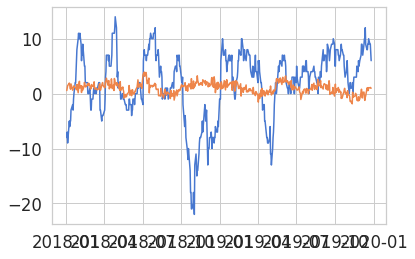

In [29]:
# Plot the predictions
plt.plot(df_predicted.iloc[:500]);

In [27]:

# ånalyse the values
df_predicted.describe().T

,count,mean,std,min,25%,50%,75%,max
short_result,32829.0,0.468458,5.894354,-40.000,-3.000,1.000,4.000,38.000
predictions,32829.0,0.483681,1.158172,-5.164,-0.224,0.472,1.192,7.052


In [28]:
# Calculation of Mean Squared Error (MSE) 
mse = round(mean_squared_error(y_test, predicted), 2)
mae = round(mean_absolute_error(y_test, predicted), 2)
r2 = round(r2_score(y_test, predicted), 2) 
print('mse: ', mse)
print('mae: ', mae)
print('r2: ', r2)

mse:  35.48
mae:  4.41
r2:  -0.02
